In [1]:
import shap
import numpy as np
import pysubgroup as ps
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from utils import DataEncoding

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
class Shap_Discovery:

    def __init__(self, train_data, target_data, attr, model=None):
        self.train_data = train_data
        self.target_data = target_data
        self.attr = attr
        self.model = model
    
    def encoding(self, data):
        label_data = data.copy()
        encoded_data = DataEncoding(label_data).label_encoding()
        return encoded_data
        
    def train_model(self, test_size=0.3, params=None):
        
        X = self.encoding(self.train_data)
        y = self.encoding(self.target_data)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
        d_train = lgb.Dataset(X_train, label=y_train)
        d_test = lgb.Dataset(X_test, label=y_test)

        params_default = {
            "max_bin": 512,
            "learning_rate": 0.05,
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": "binary_logloss",
            "num_leaves": 10,
            "verbose": -1,
            "min_data": 100,
            "boost_from_average": True
        }

        if params is None:
            params = params_default
            
        model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)
        self.model = model
        return model
    
    def get_attr_shap_values(self):
        shap_values = self.get_shap_values()
        ind = self.train_data.columns.tolist().index(self.attr)
        attr_shap_values = shap_values[:, ind]
        return attr_shap_values
    
    def get_shap_values(self):
        X = self.encoding(self.train_data)
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(X)
        return shap_values
    
    def get_shap_summary_plot(self):
        X = self.encoding(self.train_data)
        shap_values = self.get_shap_values()
        return shap.summary_plot(shap_values, X)
        
    def get_shap_dependence_plot(self):
        X = self.encoding(self.train_data)
        shap_values = self.get_shap_values()
        for name in self.train_data.columns:
            shap.dependence_plot(name, shap_values, X, display_features=X)
            
    def discovery(self):
        attr_effect = self.get_attr_shap_values()
        df_effect = self.train_data.copy()
        df_effect['effect'] = attr_effect - np.mean(attr_effect)
        target = ps.NumericTarget('effect')
        search_space = ps.create_nominal_selectors(df_effect, ignore=['effect', self.attr])
        task = ps.SubgroupDiscoveryTask(df_effect, target, search_space, qf=ps.StandardQFNumeric(1))
        result = ps.BeamSearch().execute(task)

        df_dis = ps.as_df(df_effect, result, statistics_to_show=ps.all_statistics_numeric)
        return df_dis

In [3]:
adult_data = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
adult_data = adult_data.drop(['education'], axis=1)

X = adult_data.drop('target', axis=1)
y = adult_data[['target']]
attr = 'education-num'

In [4]:
sex_discovery = Shap_Discovery(X, y, attr)
model = sex_discovery.train_model()

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[795]	valid_0's binary_logloss: 0.2769


In [15]:
pd.set_option('display.max_colwidth', -1)

In [9]:
sex_dis = sex_discovery.discovery()

In [18]:
sex_dis[['quality', 'subgroup', 'mean_sg', 'mean_dataset', 'mean_lift']]

,quality,subgroup,mean_sg,mean_dataset,mean_lift
0,3167.588644,occupation= Prof-specialty,0.765118,2.775472e-18,2.756713e+17
1,2825.186275,race= White AND occupation= Prof-specialty,0.773812,2.775472e-18,2.788036e+17
2,2783.454690,occupation= Prof-specialty AND native-country= United-States,0.753711,2.775472e-18,2.715613e+17
3,2619.158915,race= White AND occupation= Prof-specialty AND native-country= United-States,0.771930,2.775472e-18,2.781257e+17
4,2206.219151,occupation= Prof-specialty AND sex= Male,0.840464,2.775472e-18,3.028185e+17
5,1973.068997,occupation= Prof-specialty AND sex= Male AND race= White,0.840319,2.775472e-18,3.027661e+17
6,1904.821330,occupation= Prof-specialty AND sex= Male AND native-country= United-States,0.823528,2.775472e-18,2.967165e+17
7,1829.045081,marital-status= Married-civ-spouse AND occupation= Prof-specialty,0.860322,2.775472e-18,3.099733e+17
8,1639.707484,marital-status= Married-civ-spouse AND occupation= Prof-specialty AND race= White,0.858036,2.775472e-18,3.091497e+17
9,1627.696232,marital-status= Married-civ-spouse AND occupation= Prof-specialty AND sex= Male,0.897792,2.775472e-18,3.234735e+17


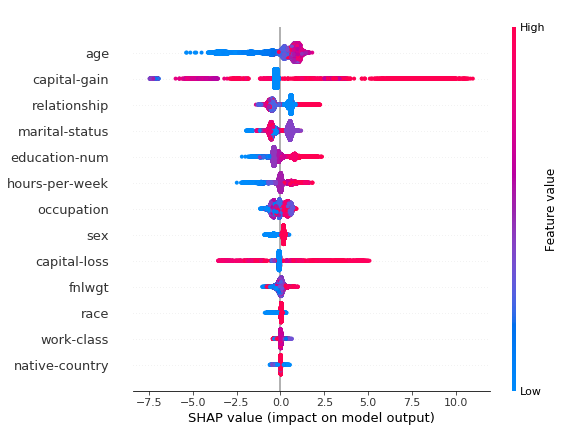

In [5]:
sex_discovery.get_shap_summary_plot()

In [243]:
# sex_discovery.get_shap_dependence_plot()

In [188]:
# adult_data = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
# adult_data = adult_data.drop(['education'], axis=1)
# data = DataEncoding(adult_data).label_encoding()
# df_adult = data

# X = df_adult.drop('target', axis=1)
# y = df_adult['target'].astype(bool)
